## Importing dependencies

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

2024-08-15 15:10:49.694837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 15:10:49.694895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 15:10:49.696422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Checking GPU availability

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Importing dataset and preprocessing

In [4]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/hagrid-classifier/hagrid-classification-512p-no-gesture-300k', shuffle=True)

Found 112392 files belonging to 8 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

## Visualizing image of each class

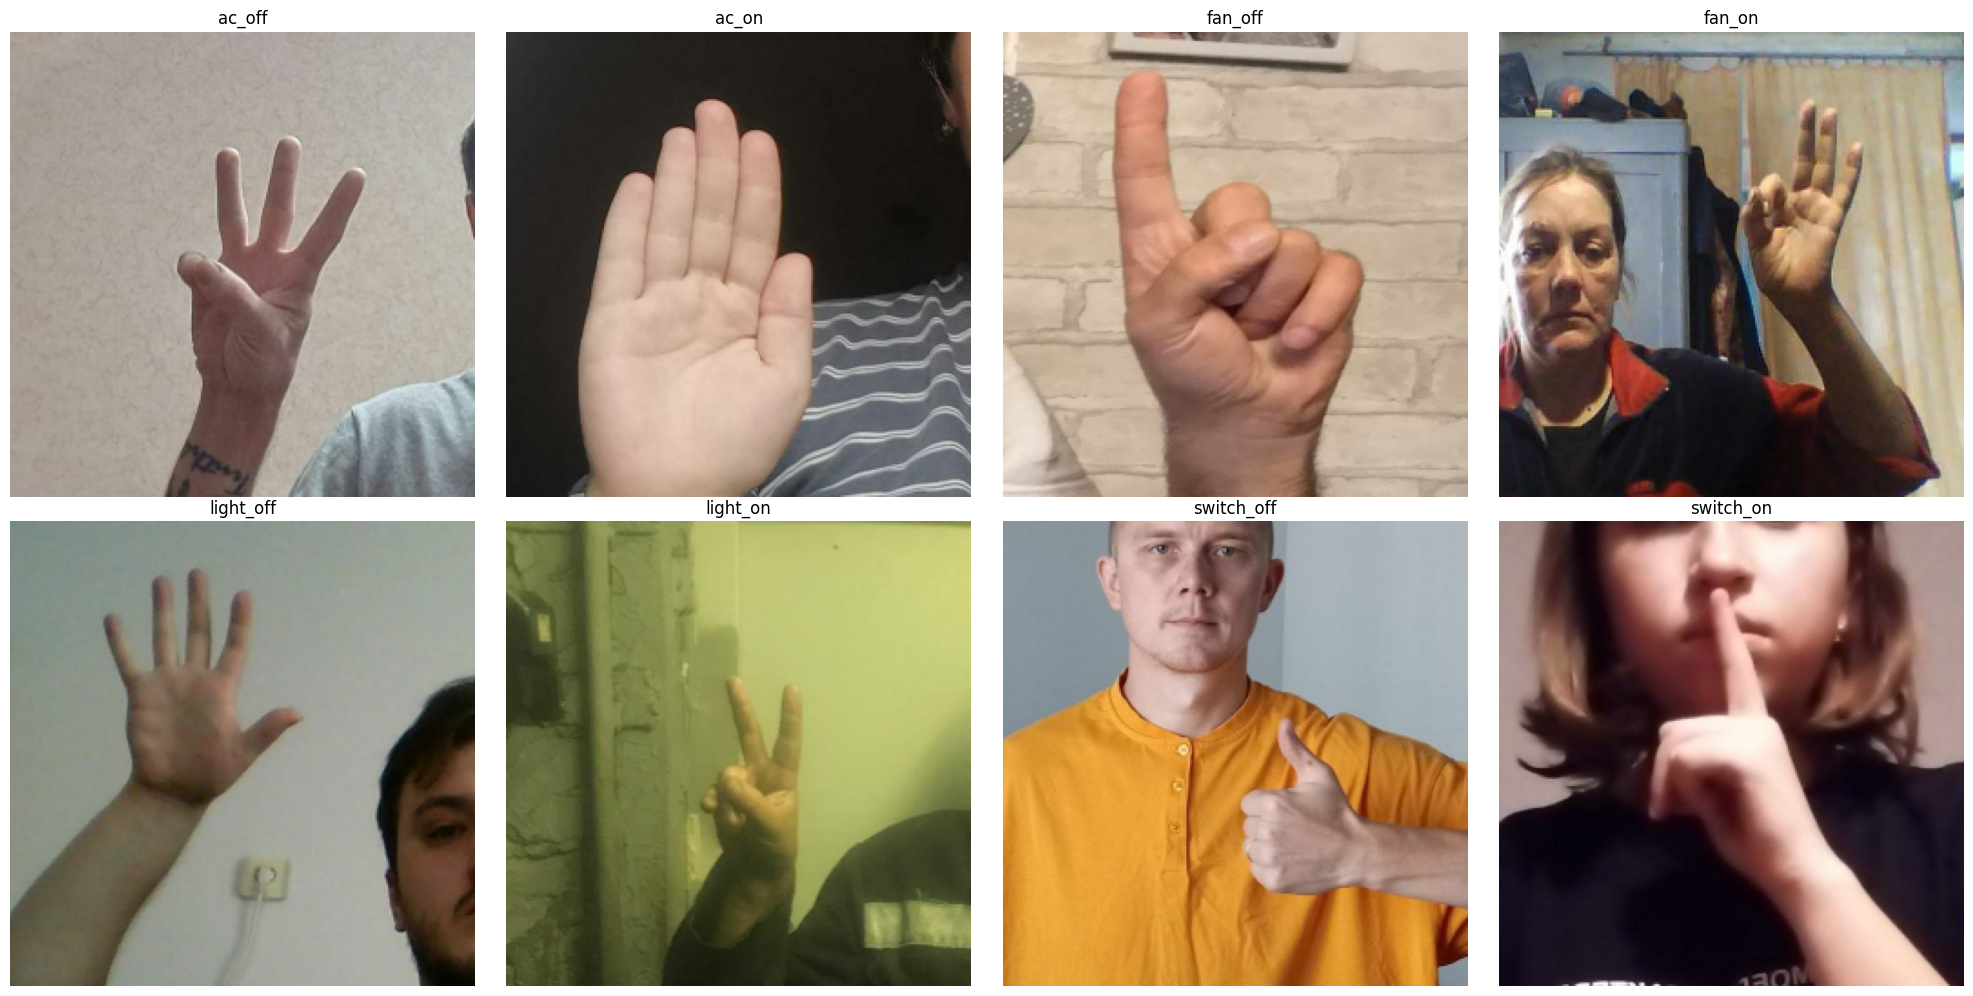

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class names from the dataset
class_names = data.class_names

# Create a dictionary to store one image per class
class_images = {name: None for name in class_names}

# Iterate through the dataset
for images, labels in data:
    for image, label in zip(images, labels):
        class_name = class_names[label]
        if class_images[class_name] is None:
            class_images[class_name] = image.numpy()
    
    # Check if we have an image for each class
    if all(img is not None for img in class_images.values()):
        break

# Visualize the images
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for ax, (class_name, image) in zip(axes, class_images.items()):
    ax.imshow(image.astype("uint8"))
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [9]:
data.as_numpy_iterator().next()

(array([[[[0.92745095, 0.7745098 , 0.5588235 ],
          [0.91764706, 0.7647059 , 0.54901963],
          [0.9196078 , 0.76666665, 0.5509804 ],
          ...,
          [0.45      , 0.4852941 , 0.26960784],
          [0.49215686, 0.52254903, 0.3019608 ],
          [0.47549018, 0.50686276, 0.27745098]],
 
         [[0.9137255 , 0.7607843 , 0.54509807],
          [0.92058825, 0.7676471 , 0.55196077],
          [0.9284314 , 0.7754902 , 0.5598039 ],
          ...,
          [0.4117647 , 0.4392157 , 0.23333333],
          [0.44215685, 0.46960783, 0.25980392],
          [0.42352942, 0.45196077, 0.23921569]],
 
         [[0.9411765 , 0.78039217, 0.5764706 ],
          [0.9490196 , 0.7882353 , 0.58431375],
          [0.9352941 , 0.7745098 , 0.57058823],
          ...,
          [0.4372549 , 0.45196077, 0.25882354],
          [0.42941177, 0.44509804, 0.24803922],
          [0.44019607, 0.45588234, 0.25882354]],
 
         ...,
 
         [[0.88039213, 0.81764704, 0.7588235 ],
          [0.87843

## Creating train and test split

In [10]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Defining Model Architecture

In [12]:
# Initialize the model
model = Sequential()

In [13]:
# First Convolutional Block
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling2D())
model.add(Dropout(0.2))  # Adjusted Dropout

# Second Convolutional Block
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling2D())
model.add(Dropout(0.25))  # Adjusted Dropout

# Third Convolutional Block
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling2D())
model.add(Dropout(0.25))  # Adjusted Dropout

# Fourth Convolutional Block
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(MaxPooling2D())
model.add(Dropout(0.3))  # Adjusted Dropout

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Added L2 Regularization
model.add(Dropout(0.4))  # Adjusted Dropout

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Added L2 Regularization
model.add(Dropout(0.4))  # Adjusted Dropout

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Added L2 Regularization
model.add(Dropout(0.4))  # Adjusted Dropout

# Output Layer
model.add(Dense(8, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Setting up callbacks and optimizers

In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False, verbose=1)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 316,936 (1.21 MB)

 Trainable params: 316,232 (1.21 MB)

 Non-trainable params: 704 (2.75 KB)

## Model training

In [17]:
# Training the model
history = model.fit(
    train,
    epochs=1000,
    validation_data=val,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

Epoch 1/1000
   2/2459 ━━━━━━━━━━━━━━━━━━━━ 3:47 92ms/step - accuracy: 0.1094 - loss: 6.9031   

I0000 00:00:1723734790.314366     250 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2459/2459 ━━━━━━━━━━━━━━━━━━━━ 295s 109ms/step - accuracy: 0.1651 - loss: 2.9364 - val_accuracy: 0.2283 - val_loss: 1.9282 - learning_rate: 0.0010
Epoch 2/1000
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 250s 102ms/step - accuracy: 0.2318 - loss: 1.8597 - val_accuracy: 0.2455 - val_loss: 1.9348 - learning_rate: 0.0010
Epoch 3/1000
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 248s 101ms/step - accuracy: 0.3509 - loss: 1.6500 - val_accuracy: 0.4183 - val_loss: 1.6576 - learning_rate: 0.0010
Epoch 4/1000
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 250s 101ms/step - accuracy: 0.5085 - loss: 1.3811 - val_accuracy: 0.5961 - val_loss: 1.2283 - learning_rate: 0.0010
Epoch 5/1000
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 251s 102ms/step - accuracy: 0.5943 - loss: 1.2305 - val_accuracy: 0.7295 - val_loss: 0.9901 - learning_rate: 0.0010
Epoch 6/1000
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 250s 101ms/step - accuracy: 0.6743 - loss: 1.0956 - val_accuracy: 0.7976 - val_loss: 0.8041 - learning_rate: 0.0010
Epoch 7/1000
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 250s 101m

## Evaluating model training metrics

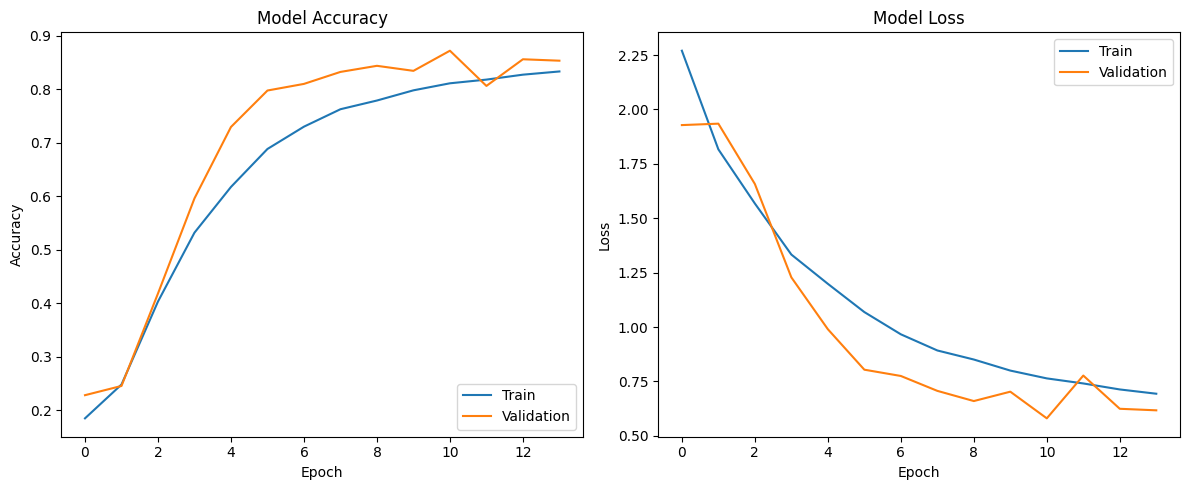

In [19]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [20]:
## saving model
model.save('/kaggle/working/classifier.h5')

## Evaluating model performance on test dataset

In [21]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

In [24]:
import os

data_dir = '/kaggle/input/hagrid-classifier/hagrid-classification-512p-no-gesture-300k'
class_names = sorted(os.listdir(data_dir))
# Remove any hidden files or directories (like .DS_Store)
class_names = [d for d in class_names if not d.startswith('.')]

In [25]:
# Make predictions on the test dataset
y_true = []
y_pred = []
for images, labels in test:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

      ac_off     0.9557    0.6872    0.7995      1413
       ac_on     0.9767    0.8580    0.9135      1366
     fan_off     0.7137    0.9431    0.8125      1388
      fan_on     0.8695    0.8462    0.8577      1417
   light_off     0.9444    0.8391    0.8886      1398
    light_on     0.7674    0.7685    0.7680      1447
  switch_off     0.7681    0.9705    0.8575      1389
   switch_on     0.9794    0.9399    0.9592      1414

    accuracy                         0.8559     11232
   macro avg     0.8719    0.8565    0.8571     11232
weighted avg     0.8716    0.8559    0.8566     11232



In [27]:
!zip -r file.zip /kaggle/working

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/classifier.h5 (deflated 13%)


In [29]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [30]:
import pickle

In [31]:
class_names

['ac_off',
 'ac_on',
 'fan_off',
 'fan_on',
 'light_off',
 'light_on',
 'switch_off',
 'switch_on']